# Assignment - 3

# 2022121008

# Prakhar Jain

**Conext**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:** 

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:** 

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



# Question 1

### 1. [1 point] Preparation. 
We will use an existing illustrative code for segmentation using a Unet in Pytorch.


Please make a copy of the following notebook as a google colab project and ensure you are able to run it:

`https://www.kaggle.com/code/dhvananrangrej/image-segmentation-with-unet-pytorch/notebook`

The first cell should contain the necessary code to download the segmentation dataset (a subset of Cityscapes).

Carefully study the code, especially focusing on the data and model.

Do not change the model definition, dataset class, or evaluation metric (currently being computed over 10 images
or 1 batch of the validation set). You may need to fix one bug `iter(data_loader).next()`, but this does not influence the other parts.

Hint: You may train the model for 1 epoch as it takes quite some time to complete all 10 epochs.

In [79]:

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from pathlib import Path

from tqdm.auto import tqdm

In [80]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [81]:
data_dir = Path("cityscapes_data")
train_dir = data_dir / "train"
val_dir = data_dir / "val"


# data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
# train_dir = os.path.join(data_dir, "train") 
# val_dir = os.path.join(data_dir, "val")


train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))
# print(f"Train Directory : {train_dir}")
# print(f"Validation Directory : {val_dir}")

2975 500


### 3. Analyze data

cityscapes_data/train/936.jpg


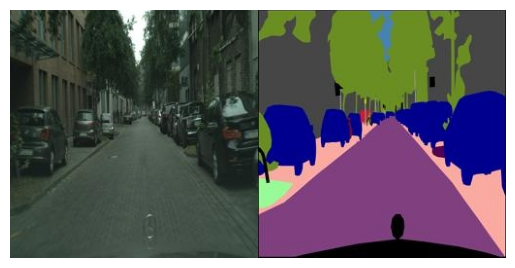

In [82]:
# sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image_fp = train_dir / train_fns[0]


sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.axis("off")

print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [83]:
def split_image(image):
  image = np.array(image)
  # print(image.shape)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

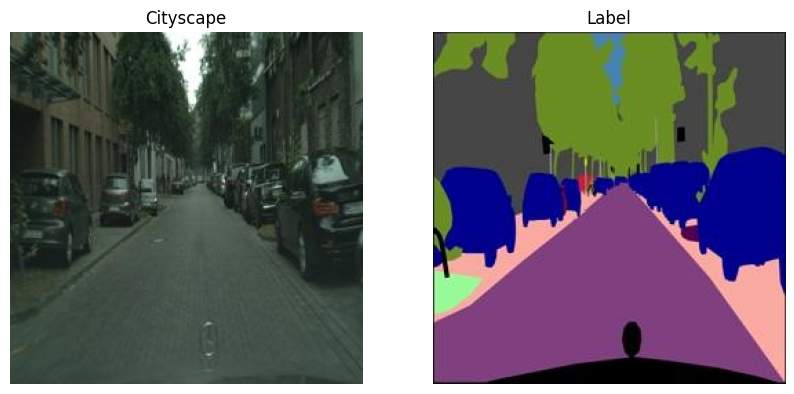

In [84]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[0].axis("off")
axes[0].set_title("Cityscape")
axes[1].imshow(label)
axes[1].axis("off")
axes[1].set_title("Label")
plt.show()

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [85]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [86]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

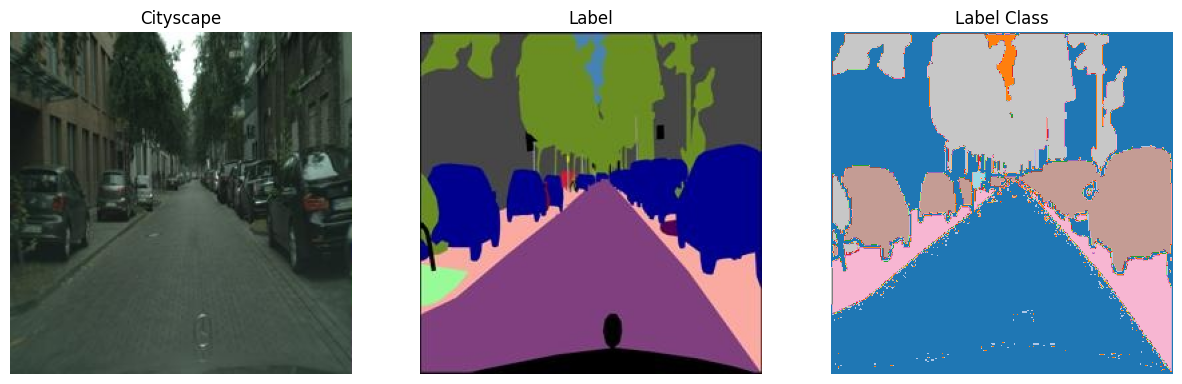

In [87]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
# plt.axis('off')
axes[0].imshow(cityscape)
axes[0].set_title('Cityscape')
axes[0].axis('off')
axes[1].imshow(label)
axes[1].set_title('Label')
axes[1].axis('off')
axes[2].imshow(label_class, cmap='tab20', vmin=0, vmax=num_classes-1)
axes[2].set_title('Label Class')
axes[2].axis('off')
plt.show()

In [88]:
# label_class

### 6. Define Dataset

In [89]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [90]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [91]:
cityscape, label_class= dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model 


In [92]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [93]:
model = UNet(num_classes = num_classes)

In [94]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

data_iter = iter(data_loader)
X, Y = next(data_iter)
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [95]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 8. Train the model

In [96]:
# def compute_iou(pred, true):
#     unique_labels = np.unique(true)
#     iou_list = []
#     for cls in unique_labels:
#         pred_idx = (pred == cls)
#         true_idx = (true == cls)
#         intersection = np.logical_and(pred_idx, true_idx).sum()
#         union = np.logical_or(pred_idx, true_idx).sum()

#         if union == 0:
#             if intersection == 0:
#                 iou_list.append(1)
#         else : 
#             iou_list.append(intersection / union)
#     return np.nanmean(iou_list)


# to account for class imbalance
def compute_iou(pred, true):
    # print(len(pred), len(true))
    unique_labels, counts = np.unique(true, return_counts=True)
    total_counts = np.sum(counts)
    # print("True :")
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label: {label}, Count: {count}")
    # unique_labels_predicted, counts_predicted = np.unique(pred, return_counts=True)
    # print("True :")
    # for label, count in zip(unique_labels_predicted, counts_predicted):
    #     print(f"Label: {label}, Count: {count}")
    
    
    iou_list = []
    for cls, count in zip(unique_labels, counts):
        pred_idx = (pred == cls)
        true_idx = (true == cls)
        intersection = np.logical_and(pred_idx, true_idx).sum()
        union = np.logical_or(pred_idx, true_idx).sum()
        # print(f"{cls} | Intersection : {intersection} | Union : {union} | Count : {count} | Total Counts : {total_counts}")

        if union == 0:
            if intersection == 0:
                iou_list.append(1)
        else : 
            iou_list.append(intersection / union)
    return np.nanmean(iou_list)
    
def compute_iou_for_batch(pred, true):
    iou_for_each_image = []
    for pre, tru in zip(pred, true):
        unique_labels, counts = np.unique(tru, return_counts=True)
        total_counts = np.sum(counts)
        
        iou_list = []
        for cls, count in zip(unique_labels, counts):
            pred_idx = (pre == cls)
            true_idx = (tru == cls)
            intersection = np.logical_and(pred_idx, true_idx).sum()
            union = np.logical_or(pred_idx, true_idx).sum()
            # print(f"{cls} | Intersection : {intersection} | Union : {union} | Count : {count} | Total Counts : {total_counts}")

            if union == 0:
                if intersection == 0:
                    iou_list.append(1)
            else:
                iou_list.append(intersection / union)
        
        iou_for_each_image.append(np.nanmean(iou_list))
    
    return iou_for_each_image

                

In [97]:
batch_size = 16

epochs = 10
lr = 0.01

In [98]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

# model here

model = UNet(num_classes = num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []
ious = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  epoch_iou = []
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    # print(X.shape[0], Y.shape[0])
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())

    # Calculate IoU
    Y_pred_argmax = torch.argmax(Y_pred, dim=1)
    # iou is a list here
    iou = compute_iou_for_batch(Y_pred_argmax.cpu().numpy(), Y.cpu().numpy())
    epoch_iou += iou
  ious.append(epoch_iou)

  epoch_losses.append(epoch_loss/len(data_loader))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [99]:
len(ious[-1])

2975

In [100]:
print(ious[-1])

[0.33934816256096695, 0.33395145011806027, 0.4034044128875767, 0.4643279051591313, 0.37135922872807425, 0.4293487604565108, 0.44833064366104364, 0.39005254213336144, 0.3148649869504906, 0.44378733371768897, 0.40011616814603196, 0.3580997450034139, 0.37332718055443376, 0.277700177758725, 0.44007070689950045, 0.4335086654748325, 0.4101728902500023, 0.41466551990229594, 0.27892077035066504, 0.29110024333424134, 0.39711967297699813, 0.4146909363571014, 0.46595816047084715, 0.3821885429982656, 0.42661534010645286, 0.2804604206743215, 0.3481246921267548, 0.4198988156657273, 0.35123316008548316, 0.34314406212198845, 0.3404897263971727, 0.3465384906380055, 0.3344454839179991, 0.39921547427927845, 0.31076389359378537, 0.2814038711149259, 0.27182311148273186, 0.4250685783188701, 0.49589194479473464, 0.5315021101944726, 0.426054557594558, 0.3125120848202969, 0.40364287797869686, 0.4301012319649565, 0.4003845876308719, 0.41493825808710166, 0.33913583558332316, 0.2925292691024854, 0.379090321241147

In [101]:
# dump step_losses and epoch_losses to a npy file
np.save("step_losses.npy", np.array(step_losses))
np.save("epoch_losses.npy", np.array(epoch_losses))


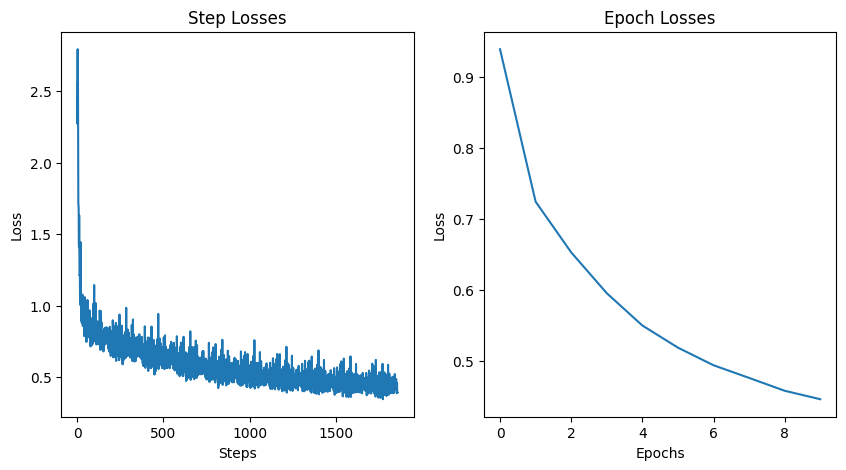

In [102]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Step Losses")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Epoch Losses")
axes[1].plot(epoch_losses)
plt.show()

In [103]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [104]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [105]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [106]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [107]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image : 0 | Mean IOU : 0.3017770365555538
Image : 1 | Mean IOU : 0.5245350384822509
Image : 2 | Mean IOU : 0.36552415877274935
Image : 3 | Mean IOU : 0.39147711859733497
Image : 4 | Mean IOU : 0.2070398978981802
Image : 5 | Mean IOU : 0.4294758955295529
Image : 6 | Mean IOU : 0.4597364966292182
Image : 7 | Mean IOU : 0.38033208152768544
Image : 8 | Mean IOU : 0.3596295563973933
Image : 9 | Mean IOU : 0.27861158832701527


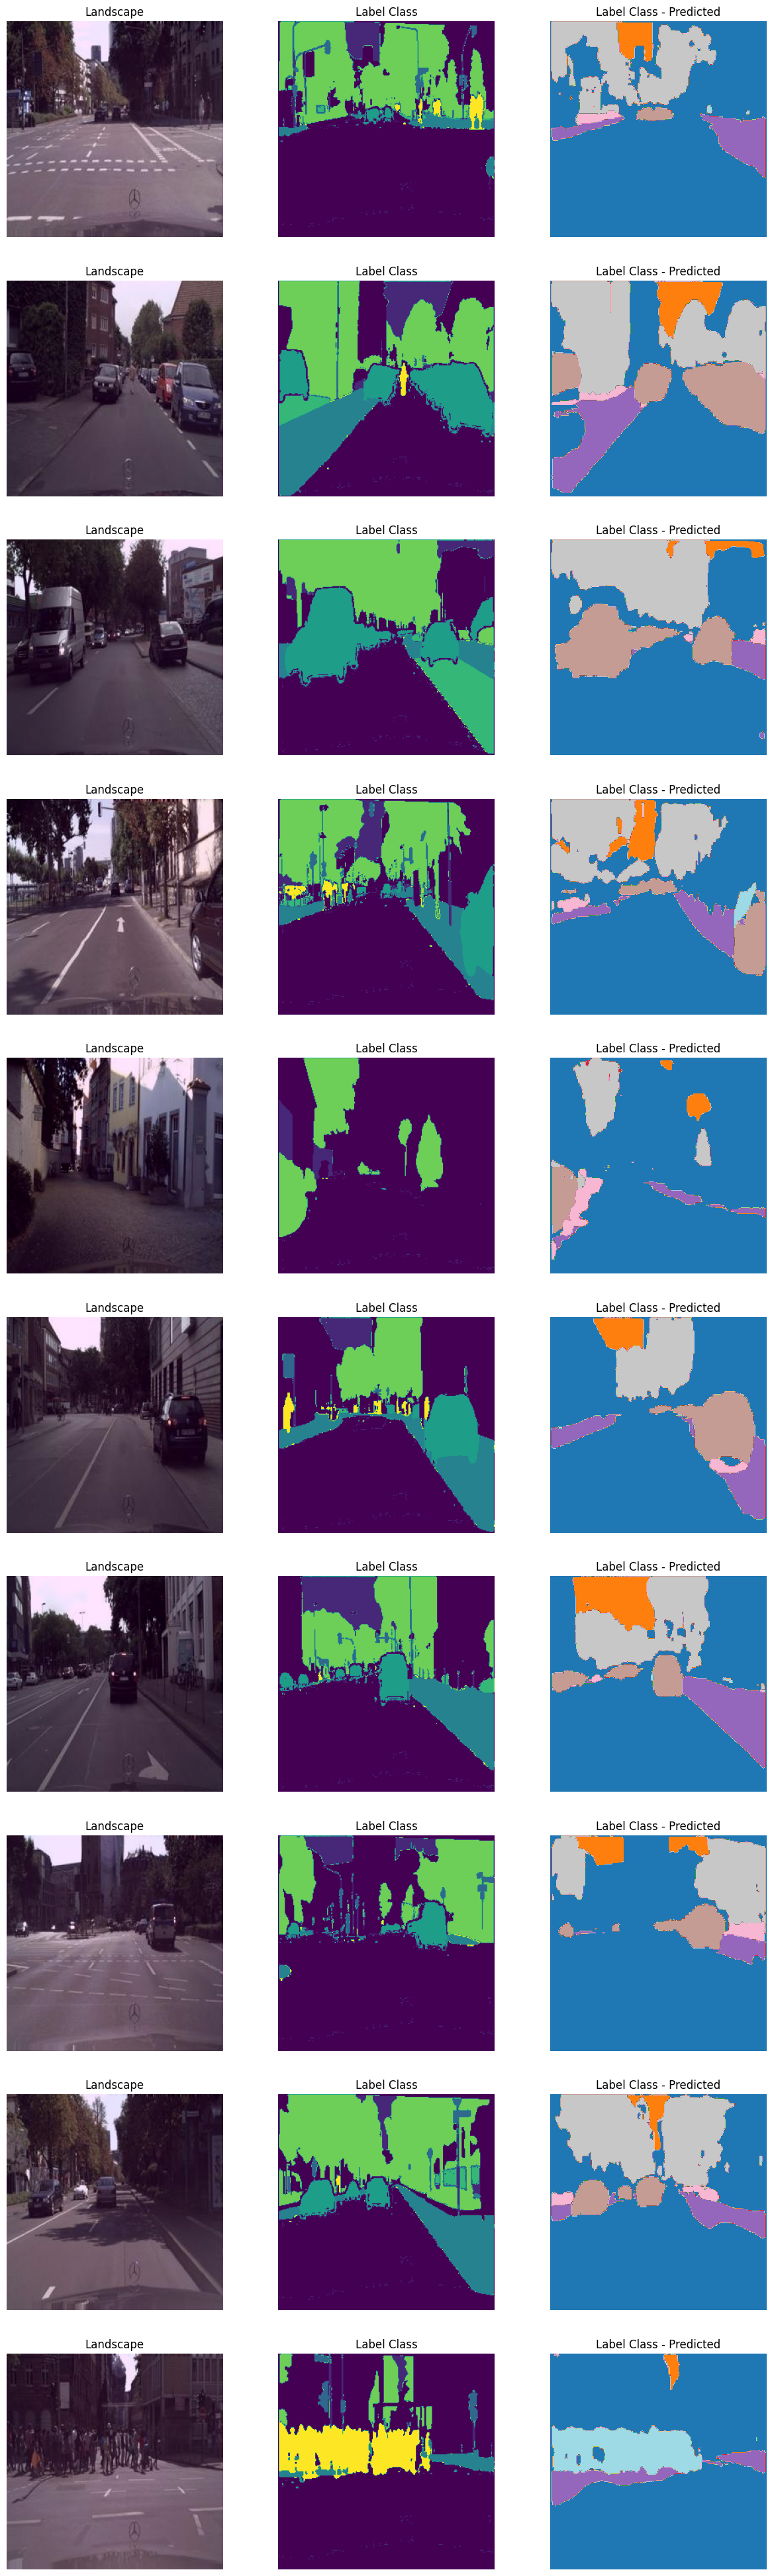

In [108]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    
    # print(f'{i} | Mean IoU: {compute_iou(label_class_predicted, label_class, num_classes)}')
    # iou_score = compute_iou(label_class_predicted, label_class, num_classes)
    iou_score = compute_iou(label_class_predicted, label_class)
    print(f"Image : {i} | Mean IOU : {iou_score}")
    iou_scores.append(iou_score)
    # IOU score
    # intersection = np.logical_and(label_class, label_class_predicted)
    # union = np.logical_or(label_class, label_class_predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='tab20', vmin=0, vmax=num_classes-1)
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Label Class - Predicted")


In [109]:
print(f"Mean IOU Score : {np.mean(iou_scores)}")

Mean IOU Score : 0.3698138868716935


# Without skip connections

In [110]:
class UNetNoSkipConnections(nn.Module):
    
    def __init__(self, num_classes):
        super(UNetNoSkipConnections, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 256, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [111]:
batch_size = 16

epochs = 10
lr = 0.01

In [112]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [113]:
model = UNetNoSkipConnections(num_classes = num_classes).to(device)

In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [115]:

step_losses = []
epoch_losses = []
ious = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  epoch_iou = []
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    # print(X.shape[0], Y.shape[0])
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())

    # Calculate IoU
    Y_pred_argmax = torch.argmax(Y_pred, dim=1)
    # iou is a list here
    iou = compute_iou_for_batch(Y_pred_argmax.cpu().numpy(), Y.cpu().numpy())
    epoch_iou += iou
  ious.append(epoch_iou)

  epoch_losses.append(epoch_loss/len(data_loader))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [116]:
len(ious[-1])

2975

In [117]:
print(ious[-1])

[0.3126252095531194, 0.30235712453760666, 0.38189981367261905, 0.4488734591328206, 0.3668967548362015, 0.38294072297604687, 0.4344721015589295, 0.379177836529146, 0.2709217512773753, 0.35604417687038314, 0.37985346419271293, 0.34000737560864214, 0.386695673340886, 0.24960415512752737, 0.3895020530911999, 0.4002771976989576, 0.38589349523786615, 0.4029990214667213, 0.25889356006570413, 0.28365366085986915, 0.3848425609508846, 0.3606697685152901, 0.3948926249787593, 0.3143329204831472, 0.43080944673700705, 0.2576705561889104, 0.3466864960995278, 0.39275615553404875, 0.3263267523704561, 0.30693154290428243, 0.3297669451560824, 0.3633056768321265, 0.30322263578331166, 0.37472095182871823, 0.2894511912195437, 0.2546141865695296, 0.24086610211829146, 0.4118043659591691, 0.4273816296712595, 0.50835557935996, 0.3919954096587463, 0.3004035768732063, 0.3603493247585146, 0.40215954715671054, 0.3600280689191313, 0.3501274179632282, 0.31996673425471106, 0.25890021516246037, 0.3354265837542926, 0.23

In [118]:
# dump step_losses and epoch_losses to a npy file
np.save("step_losses_no_skip_connections.npy", np.array(step_losses))
np.save("epoch_losses_no_skip_connections.npy", np.array(epoch_losses))


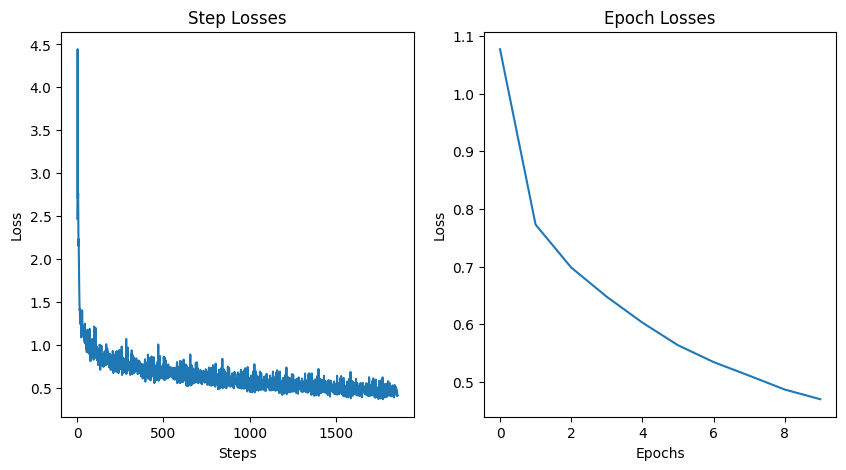

In [119]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Step Losses")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Epoch Losses")
axes[1].plot(epoch_losses)
plt.show()

In [120]:
model_name = "U-Net-no-skip-connection.pth"
torch.save(model.state_dict(), model_name)

In [121]:
model_path = "U-Net-no-skip-connection.pth"
model_ = UNetNoSkipConnections(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [122]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [123]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [124]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image : 0 | Mean IOU : 0.25409668736167923
Image : 1 | Mean IOU : 0.4985211393914122
Image : 2 | Mean IOU : 0.36060948224614303
Image : 3 | Mean IOU : 0.36099887522613106
Image : 4 | Mean IOU : 0.22910814908892316
Image : 5 | Mean IOU : 0.4115463973726523
Image : 6 | Mean IOU : 0.44416786470793695
Image : 7 | Mean IOU : 0.3418332063620143
Image : 8 | Mean IOU : 0.3525912073013452
Image : 9 | Mean IOU : 0.1810178900808252


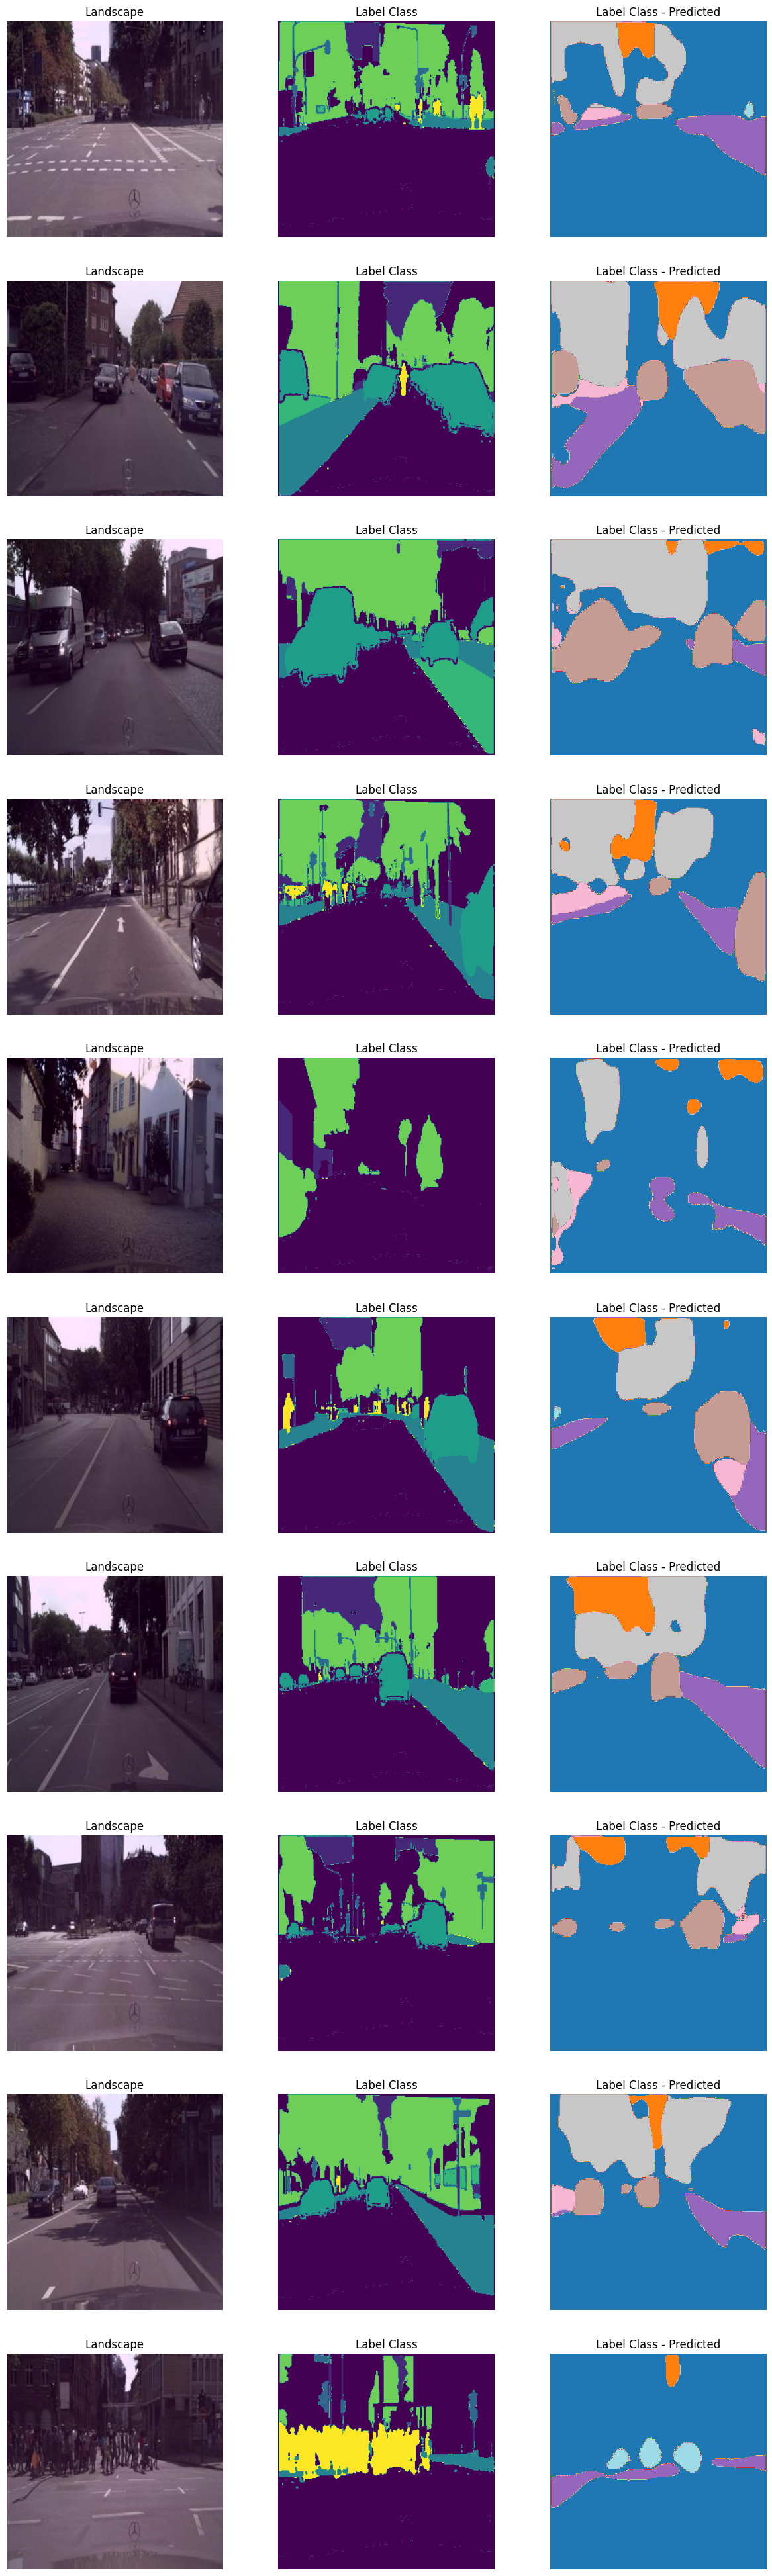

In [125]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    iou_score = compute_iou(label_class_predicted, label_class)
    print(f"Image : {i} | Mean IOU : {iou_score}")
    iou_scores.append(iou_score)
    
    # IOU score
    # intersection = np.logical_and(label_class, label_class_predicted)
    # union = np.logical_or(label_class, label_class_predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='tab20', vmin=0, vmax=num_classes-1)
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Label Class - Predicted")

In [126]:
print(f"Mean IOU Score : {np.mean(iou_scores)}")

Mean IOU Score : 0.34344908991390627


### 2. [2 points] Importance of skip connections

The above model is a standard Unet architecture. The key
novelty in the Unet are the skip connections between the encoder and decoder. But how important are they?
In this experiment, modify the model to disconnect the skip connections. As compared to the original model,
does the new model perform well? Report the results, both qualitatively and quantitatively (IoU over the same
10 images as before).

**Hint 1:** When removing the skip connections, you will need to halve the number of input channels too.

**Hint 2:** For a fair comparison to the above model, please train the new model without skip connections for the
same number of epochs (1 if you followed the above point!).


- With connections (original model), the IoU for validation is 0.3698.
- Without connections (modified model), the IoU for validation is 0.3434.

This indicates that the skip connections are indeed important for the performance of the model, providing a qualitative improvement in the segmentation results.

The model with skip connections is able to capture the fine details in the segmentation masks. The model without skip connections is not able to capture the fine details and the boundaries are very smooth.

### 3. [1 point] Metric
The metric implemented in the notebook calculates IoU directly (`logical_and` and `logical_or`)
and does not seem correct.
First, explain what is the issue with the metric in the current form.
Next, re-write the metric function to instead compute an IoU for each class. Report the mean over all classes as
the score for each image, and the mean over all images as the score for the validation set (or 10 images therein).
Is the mIoU score different between the model with and without skip connections? Explain why

Yes, the mean Intersection over Union (mIoU) score is different between the models with and without skip connections based on the scores.

- With skip connections: mIoU = 0.3698

- Without skip connections: mIoU = 0.3434

The mIoU score has decreased when skip connections were removed, which suggests that the model without skip connections performs worse in terms of accurately segmenting the various classes in the images. 

- Skip connections allow the network to reuse features from earlier layers directly in deeper layers. This means that detailed spatial information that could be lost during downsampling is retained, improving the quality of the segmentation.

- In segmentation tasks, combining the high-level contextual information (which determines what the object is) with low-level details (which determine the exact boundaries of objects) is crucial. Skip connections effectively provide a shortcut for this combination.